In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import random
import csv
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import dirichlet
from scipy.stats import norm
%matplotlib inline

In [9]:
import glob
for file in glob.glob("../*"):
    print(file)

..\CHANGELOG.md
..\CONTRIBUTING.md
..\LICENSE
..\OutputFiles
..\SourceFiles
..\mkdocs.yml
..\notebooks
..\noxfile.py
..\readme.md
..\setup.py
..\waterisomix


In [11]:
import sys
hydropath = "../"
sys.path.append(hydropath)
import waterisomix

From https://doi.org/10.1007/s00442-018-4192-5

https://github.com/SPATIAL-Lab/watercompare 

# Figure 1

In [12]:
#####
#--- theoretical concepts plots ----
#####

#parameter values
nits = 10 #num evap samples
s = 4.5 #EL slope
ssd = 0.5 #slope SD

#prescribed X/Y for sources
swo = [-10.2, -8.5, -5.7, -6.8]
isot = pd.Series(swo, name='swo').to_frame()
isot['swh'] = isot['swo'] * 8 + 10 + np.random.normal(size=4)

def randiso(x):
    enro = np.random.uniform(size=nits)*5
    x['ewo'] = x['swo'] + enro
    x['ewh'] = x['swh'] + enro * (4.5+np.random.normal(size=nits)*ssd)
    return x

isot = isot.apply(lambda x: randiso(x), 1)

#generate samples for correlated model
mths = 12
enoise = 1
seas = (np.sin(2*np.pi*np.arange(0,mths)/mths))
seaso = isot['swo'].mean() + (isot['swo'].max() - isot['swo'].min()/1.5) * seas
seash = seaso * 8 + 10 + np.random.normal(size=mths)
enro = (seas + 1.5) * 2.5 + np.random.normal(size=mths) * enoise
seaseo = seaso + enro
seaseh = seash + enro * (4.5 + np.random.normal(size=mths)*ssd)

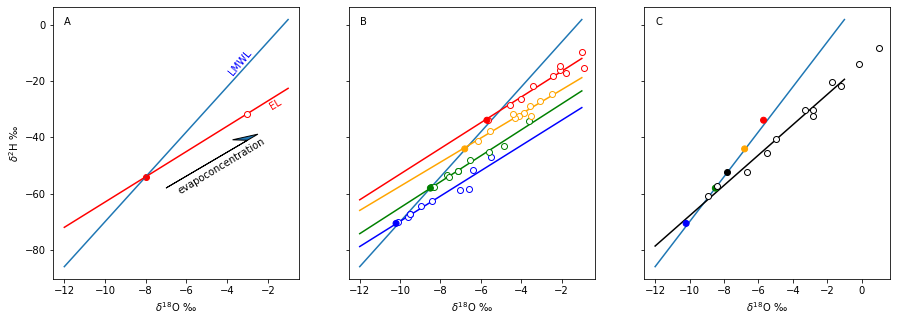

In [13]:
from scipy import stats
fig, ax = plt.subplots(1,3,sharey=True,figsize=(15,5))
x1 = np.arange(-12,0,1)
y1 = [8*i + 10 for i in x1]
y2 = [4.5*i + 10-8*3.5 for i in x1]
ax[0].plot(x1,y1)
ax[0].plot(x1,y2,color='red')
ax[0].scatter(-8,-54, color='red')
ax[0].scatter(-3,-54+5*4.5,edgecolor='red',color='white',zorder=10)
ax[0].set_ylabel(r'$\delta^{2}$' + 'H ' + u'\u2030')
ax[0].text(-4,-18,'LMWL',rotation=50,color='blue')
ax[0].text(-2,-30,'EL',rotation=31,color='red')
ax[0].text(-6.5, -60, "evapoconcentration", rotation=31)
ax[0].text(-12,0,'A')
ax[1].text(-12,0,'B')
ax[2].text(-12,0,'C')
ax[0].arrow(-7,-58,4,17,head_width=1.5,shape='right')
for i in range(len(ax)):
    ax[i].set_xlabel(r'$\delta^{18}$' + 'O ' + u'\u2030')
ax[1].plot(x1,y1)

isot['colors'] = ["blue", "green", "red", "orange"]

for i in isot.index:
    slope, intercept, r_value, p_value, std_err  = stats.linregress(isot.loc[i,'ewo'], isot.loc[i,'ewh'])
    ax[1].scatter(isot.loc[i,'ewo'],isot.loc[i,'ewh'],edgecolor=isot.loc[i,'colors'],color='white',zorder=15)
    ax[1].plot(x1,[slope*j+intercept for j in x1],color=isot.loc[i,'colors'])
ax[1].scatter(isot['swo'], isot['swh'], color=["blue", "green", "red", "orange"],zorder=15)    
ax[2].plot(x1,y1)
ax[2].scatter(seaseo,seaseh,edgecolor='black',color='white',zorder=15)
slope, intercept, r_value, p_value, std_err  = stats.linregress(seaseo,seaseh)
ax[2].plot(x1,[slope*j+intercept for j in x1], color='black')
ax[2].scatter(isot['swo'], isot['swh'], color=isot['colors'],zorder=11)
ax[2].scatter(np.mean(seaso), np.mean(seash), color='black',zorder=11)


Hypothetical examples illustrating iSWE applications. <br>
<p> A. Theoretical framework. Source water values (solid red circle) lie along a
local meteoric water line (LMWL). An evapoconcentrated water sample
(open red circle) has H and O isotope ratios that have evolved relative
to the source along an evaporation line (EL). Measured source
values are back-projected along the EL to its intersection with the
LMWL to estimate the source water values. </p><br>
<p> B. Multiple water samples (open symbols) derived from one of four different ‘source waters’
(solid circles) with random noise and without mixing. In this case, a
regression line fit to each group of evapoconcentrated water samples
approximates the evaporation line slope (true value of 4.5 ± 0.5, estimated
values between 4.24 and 4.74) and projects to an intersection
with the LMWL approximating the actual source water value. </p><br>
<p> C. Multiple evapoconcentrated water samples (open symbols) derived from
varying mixtures of the four sources shown in B. The model shown
includes sinusoidal variation in source water values that is positively
correlated with evapoconcentration, reflecting correlated seasonal
variation in source water isotope ratios and evaporative losses. In this
case, the regression fit over-estimates the EL slope (5.5) and the intercept
between this line and the LMWL gives an estimate of the source
water isotope values that is lower than the true average value (black
solid circle). This figure is available in color in the online version of
the journal</p><br>

# Figure 2

In [9]:
#illustrate case
hsource = waterisomix.iso(-46, -7, 1.6, 0.2, 0.8)
obs = waterisomix.iso(-27, -3, 0.25, 0.05, 0)

#hypothesized slope value (slope, sd)
hslope = [4.5, 0.3]

#get results and report average conditional probability for test case
results = waterisomix.sourceprob(obs, hsource, hslope, ngens=10000)
cond = np.sum(results['Sprob']/len(results))

In [10]:
results.head()

,H_obs,O_obs,obs_prob,H_h,O_h,hypo_prob,slope,Sprob,msk
0,-27.265742,-2.991158,7.124674,-48.948373,-7.286928,0.151431,5.047438,0.189203,1
1,-27.038488,-2.856117,0.200258,-45.043703,-6.834609,0.585546,4.525638,0.996355,1
2,-27.118064,-2.996031,11.353036,-46.154432,-7.042305,0.804665,4.704666,0.792382,1
3,-26.805567,-2.937039,4.258454,-43.410850,-6.668998,0.186865,4.449482,0.985922,1
4,-27.332822,-2.974474,4.607415,-47.505468,-7.110171,0.503142,4.877689,0.452714,1


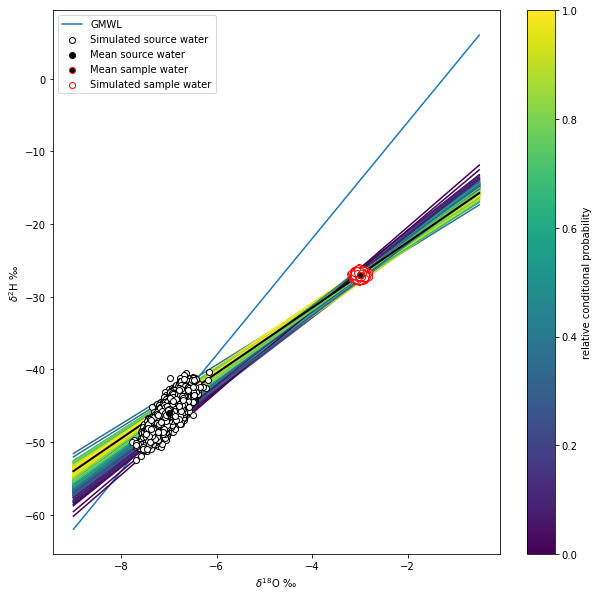

In [7]:
#plt.plot(results['O_h'],results['H_h'])
from matplotlib import cm
fig, ax = plt.subplots(1,1,figsize=(10,10) )
nex = 250
results['S'] = (results['H_obs']-results['H_h'])/(results['O_obs']-results['O_h'])
results['b'] = results['H_obs'] - results['S'] * results['O_obs']
x = np.arange(-9,0,0.5)
y = [8*i + 10 for i in x]
ax.plot(x,y,label="GMWL")
for i in results.index[:250]:
    ax.plot(x,[results.loc[i,'S']*j +results.loc[i,'b'] for j in x], 
            color=cm.viridis(results.loc[i,'Sprob']))
ax.scatter(results['O_h'],results['H_h'],edgecolor='black',color='white',zorder=1000,
           label='Simulated source water')
ax.scatter(hsource.O, hsource.H, color="black",zorder=1001,label='Mean source water')
ax.scatter(obs.O, obs.H, edgecolor="red", color="black",zorder=1001,label='Mean sample water')
ax.scatter(results['O_obs'],results['H_obs'],edgecolor='red',color='white',zorder=1000,
          label='Simulated sample water')
ax.legend()
b = ax.plot(x, [hslope[0]*k + obs['H'] - obs['O'] * hslope[0] for k in x],color='black',linewidth=2,zorder=999)
ax.set_ylabel(r'$\delta^{2}$' + 'H ' + u'\u2030')
ax.set_xlabel(r'$\delta^{18}$' + 'O ' + u'\u2030')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
cbar = plt.colorbar(sm)
cbar.set_label('relative conditional probability')
#fig.colorbar(cm.viridis(results['Sprob']))

# Figure 3

In [20]:

def runslope(hslope, Hsd = 1.6, Osd = 0.2, HOc = 0.8, ngns=1000):
    niter  = 50
    hsource_o = np.arange(-9, -5, 4/(niter-1))#
    
    ppost=[]
    for i in range(niter):
      hsource = waterisomix.iso(8*hsource_o[i]+10, hsource_o[i], Hsd, Osd, HOc)
      results = waterisomix.sourceprob(obs, hsource, hslope, ngens=ngns)
      ppost.append(sum(results['Sprob'])/len(results))
    ppost = [i/np.max(ppost) for i in ppost]
    return hslope, ppost, hsource_o

Text(0, 0.5, 'Relative conditional probability')

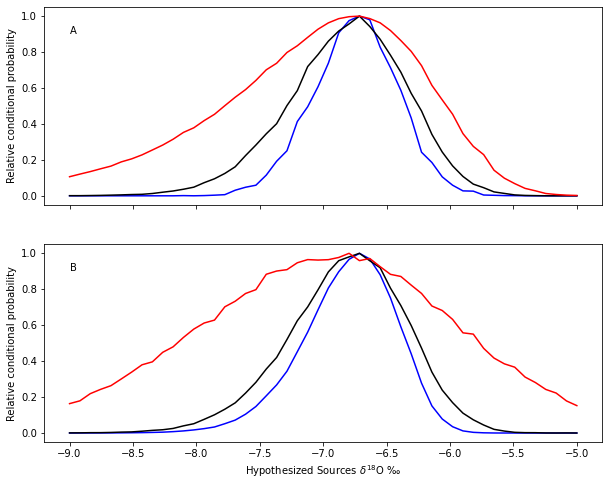

In [22]:
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)

#vary standard deviation and leave slope alone for prior
#case for precisely known EL slope
hslope = [4.5, 0.1]
hslope, ppost, hsource_o = runslope(hslope)
ax[0].plot(hsource_o, ppost, color="blue")

#default case
hslope = [4.5, 0.3]
hslope, ppost, hsource_o = runslope(hslope)
ax[0].plot(hsource_o, ppost, color="black")

#poorly known slope case
hslope = [4.5, 0.6]
hslope, ppost, hsource_o = runslope(hslope)
ax[0].plot(hsource_o, ppost, color="red")
ax[0].text(-9,0.9,'A')
ax[0].set_ylabel('Relative conditional probability')


# vary source info and leave slope variation and mean constant
hslope = [4.5, 0.3]

#precisely known (e.g. measured) source
hslope, ppost, hsource_o = runslope(hslope, 0.25, 0.05, 0)
ax[1].plot(hsource_o, ppost, color="blue")

#default case
hslope, ppost, hsource_o = runslope(hslope, 1.6, 0.2, 0.8)
ax[1].plot(hsource_o, ppost, color="black")

#poorly known (e.g. modeled) source
hslope, ppost, hsource_o = runslope(hslope, 5, 0.5, 0.8, ngns=5000)
ax[1].plot(hsource_o, ppost, color="red")
ax[1].text(-9,0.9,'B')
ax[1].set_xlabel('Hypothesized Sources '+r'$\delta^{18}$' + 'O ' + u'\u2030')
ax[1].set_ylabel('Relative conditional probability')

Fig. 3 Sensitivity test of single-source iSWE implementation. 
<p> A. Sensitivity test showing posterior probabilities for hypothesized source
waters with mean values on the GMWL. Parameters are as in Fig. 2
(black line), or as in Fig. 2 except for the standard deviation of the
EL slope (0.1 for the blue curve and 1.0 for the red curve).</p><br> 
<p> B. As in a, except the EL slope uncertainty is 0.3 for all curves and hypothesized
source water uncertainties (δ2Hsd, δ18Osd, Cov) are {0.25, 0.05, 0}
and {5, 0.5, 0.8} for the blue and red curves, respectively. This figure
is available in color in the online version of the journal.</p>

# Figure 4

In [26]:
#####
#--- illustrate MWL source implementation ----
#####

#sample values
obs = waterisomix.iso(-27, -3, 0.25, 0.05, 0)

#hypothesized slope value (slope, sd)
hslope = [4.5, 0.3]

ngens=5000
mwl=[8.01, 9.57, 167217291.1, 2564532.2, -8.096, 80672]

mean = [obs['H'][0], obs['O'][0]]
sigma = [[obs['Hsd'][0] ** 2, obs['HOc'][0] * obs['Hsd'][0] * obs['Osd'][0]],
         [obs['HOc'][0] * obs['Hsd'][0] * obs['Osd'][0], obs['Osd'][0] ** 2]]

#demonstrate the prior distribution of sources
#ngens observed values
s = np.random.multivariate_normal(mean, sigma, ngens)
HO_obs = pd.DataFrame(s, columns=['H_obs', 'O_obs'])

#bivariate normal probability density for each obs draw
HO_obs['obs_prob'] = HO_obs[['H_obs', 'O_obs']].apply(lambda x: multivariate_normal.pdf(x, mean=mean, cov=sigma), 1)

#ngens d18O from uniform distribution
o_min = -17
o_max = -2
O_h = o_min + np.random.uniform(size=ngens) * (o_max - o_min)

#draw d2H using mwl variance
sr = np.sqrt((mwl[2] - (mwl[0]**2 * mwl[3]))/(mwl[5]-2))  ##sum of squares
sy = sr * np.sqrt(1 + 1 / mwl[5] + (O_h - mwl[4])**2 / mwl[3])  ##prediction standard error, e.g., http://science.widener.edu/svb/stats/regress.html and http://www.real-statistics.com/regression/confidence-and-prediction-intervals/
H_h = np.random.normal(O_h * mwl[0] + mwl[1], sy,ngens)

hypo_prob = norm.pdf(H_h, O_h * mwl[0] + mwl[1], sy)   #normal probability density for each hypo draw

results = pd.DataFrame([H_h, O_h, hypo_prob, 
                        HO_obs['H_obs'], HO_obs['O_obs'], HO_obs['obs_prob']],
                      ['H_h', 'O_h', 'hypo_prob', 'H_obs', 'O_obs', 'obs_prob']).T

In [43]:
results.head()

,H_h,O_h,hypo_prob,H_obs,O_obs,obs_prob
0,-93.902510,-13.810294,0.032070,-26.641932,-3.020910,4.182900
1,-71.305903,-10.015621,0.068817,-26.939244,-2.899833,1.661879
2,-93.692175,-13.355095,0.056271,-26.528081,-2.984775,2.046498
3,-11.114408,-2.949327,0.060801,-27.095065,-3.067322,4.784555
4,-113.543701,-14.426563,0.029291,-27.573529,-3.036190,0.705202


In [97]:
results2 = waterisomix.mwlsource(obs, hslope, [8.01, 9.57, 167217291.1, 2564532.2, -8.096, 80672], ngens=2000)

<AxesSubplot:xlabel='$\\delta^{18}$O ‰', ylabel='$\\delta^{18}$O ‰'>

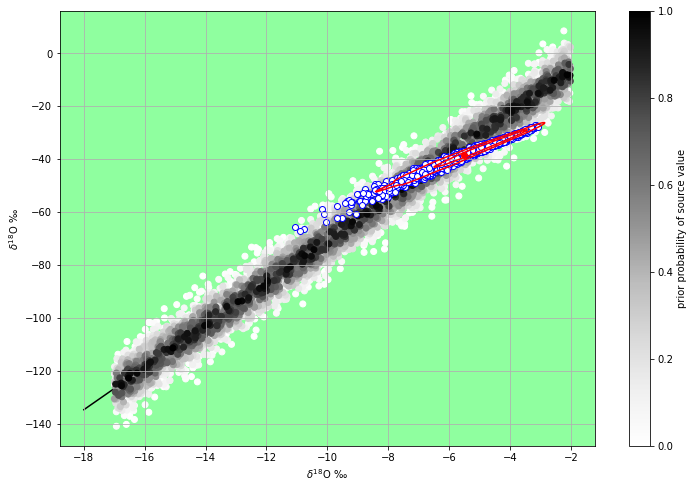

In [100]:
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(12,8))
results['pointcol'] = (results['obs_prob'] * results['hypo_prob'])/np.max(results['obs_prob'] * results['hypo_prob'])
subres = results.iloc[:ngens].sort_values('pointcol',ascending=True)
normalize = matplotlib.colors.Normalize(vmin=0, vmax=1)
sdata = ax.scatter(subres['O_h'],subres[:ngens]['H_h'], c=subres['pointcol'], cmap='Greys', norm=normalize)
cbar = plt.colorbar(sdata)
ax.set_facecolor('xkcd:mint green')
plt.xlabel(r'$\delta^{18}$' + 'O ' + u'\u2030')
plt.ylabel(r'$\delta^{18}$' + 'O ' + u'\u2030')
plt.plot(range(-18,-1),[8.01*i+9.57 for i in range(-18,-1)],zorder=0,color='black')
plt.scatter(results2['O_h'],results2['H_h'],edgecolor='blue',facecolor='white')
plt.scatter(results2['O_h'].mean(),results2['H_h'].mean(),color='red')
cbar.set_label("prior probability of source value")
plt.grid()
sns.kdeplot(data=results2, x="O_h", y="H_h",color='red',levels=[0.1,0.5])

Fig. 4 Hypothetical application of MWL source iSWE implementation.
White-filled circles with black/gray outlines show the prior distribution
of potential source values. These are generated by drawing
δ18Oh from a uniform distribution and drawing accompanying δ2Hh
values from a normal distribution specified by the mean and standard
error of the GMWL equation at the given value of δ18Oh. Darkness of
the symbol outlines scales linearly with the prior probability of that
source value. Circles with blue outlines show posterior distribution of
10,000 potential source values. Red-outlined black circle shows the
observed sample value, and the red filled circle and lines show the
median and 90 and 95% credible regions for the posterior distribution.
Observed sample values and slope used the simulation are as in
Fig. 2. This figure is available in color in the online version of the
journal

# Figure 5

In [14]:
#####
#--- illustrate mixtures implementation ----
#####

#observed value (H, O, Hsd, Osd, HOcorrelation)
obs = waterisomix.iso(-27, -3, 0.25, 0.05, 0)

#hypothesized source values (data frame; H, O, Hsd, Osd, HOcorrelation)
O = [-9, -3]
H = [Oi*8 + 10 for Oi in O]
Hsd = [1.6]*len(H)
Osd = [0.2]*len(H)
HOc = [0.8]*len(H)
hsource = waterisomix.iso(H,O,Hsd,Osd,HOc)

#hypothesized slope value (slope, sd)
hslope = [4.5,0.3]

#case with generic prior
results = waterisomix.mixprob(obs, hsource, hslope, prior=[2,2])

prior = np.random.dirichlet([2,2],size=10000)
pr = pd.DataFrame(prior,columns=['xa','xb'])

#case with informative prior
results2 = waterisomix.mixprob(obs, hsource, hslope, prior=[4,2])
#simulate prior for plotting
prior2 = np.random.dirichlet([4,2],size=10000)
pr2 = pd.DataFrame(prior2, columns=['xa','xb'])
results2['X1'] = results2['fracs'].apply(lambda x: x[0],1)

2
2
46589 iterations for 10000 posterior samples


In [21]:
results.head()

,H_h,O_h,hypo_prob,H_obs,O_obs,obs_prob,fracs,fracs_prob,Sprob
1,-57.055516,-9.163341,0.155577,-26.976299,-2.954942,8.445308,"[0.7564765131543586, 0.24352348684564143]",1.105319,0.516358
2,-48.199837,-7.848716,0.147330,-26.860252,-2.942140,5.575314,"[0.6496976861394428, 0.35030231386055727]",1.365544,0.881289
3,-46.645851,-7.396750,0.264421,-26.690913,-2.976949,5.331312,"[0.631649836863435, 0.3683501631365652]",1.396010,0.998768
4,-44.161986,-6.953087,0.023642,-26.647363,-2.985241,4.507575,"[0.58582662270124, 0.4141733772987601]",1.455803,0.959871
5,-51.384766,-8.209802,0.179644,-27.142623,-3.013758,10.418300,"[0.6701173463746942, 0.32988265362530583]",1.326361,0.858845


C:\ProgramData\Anaconda3\envs\mcmc\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\mcmc\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\mcmc\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

<AxesSubplot:xlabel='xa', ylabel='Density'>

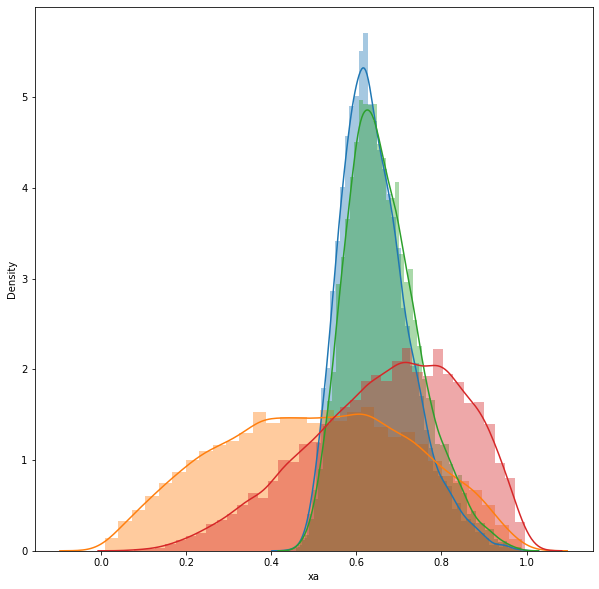

In [32]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(10,10))
results['X1'] = results['fracs'].apply(lambda x: x[0],1)
sns.distplot(results["X1"], ax=ax)
sns.distplot(pr['xa'], ax=ax)

sns.distplot(results2["X1"], ax=ax)
sns.distplot(pr2['xa'], ax=ax)

# Scratch Space

In [ ]:

#run the test case
results = mwlsource(obs, c(8.01, 9.57, 167217291.1, 2564532.2, -8.096, 80672), hslope)

#some summary information
dens = kde2d(results$O_h, results$H_h, n=250)
mean(results$H_h)
mean(results$O_h)
quantile(results$H_h, c(0.05, 0.1, 0.5, 0.9, 0.95))
quantile(results$O_h, c(0.05, 0.1, 0.5, 0.9, 0.95))

#poor man's credible regions - show areas in H/O space containning highest X% of densities
dz = as.vector(dens$z)   #extract densities to vector
dzf = data.frame("indx"=seq(1:length(dz)), "val"=dz, "sm"=rep(0), "quant"=rep(0))  #bundle w/ other useful stuff
dzf = dzf[order(-dzf$val),]  #sort by gridcell density
rs=0
for(i in 1:nrow(dzf)){   #accumulate density
  rs = rs + dzf$val[i]
  dzf$sm[i] = rs
}
dzf$quant = ifelse(dzf$sm < 0.95*rs, 0.95, dzf$quant)   #classify using cum dens thresholds
dzf$quant = ifelse(dzf$sm < 0.90*rs, 0.90, dzf$quant)
dzf = dzf[order(dzf$indx),]   #reorder to original 
densq = dens
densq$z = matrix(dzf$quant, 250, 250)   #pop back into original structure

#overlay posterior
points(results$O_h[1:nex],results$H_h[1:nex], pch=21, bg="white", col="blue")
points(obs$O, obs$H, pch=21, col="red", bg="black")    
points(quantile(results$O_h, 0.5), quantile(results$H_h, 0.5), pch=21, col="red", bg="red")   
xlim=c(par("usr")[1], par("usr")[2])
ylim=c(par("usr")[3], par("usr")[4])
contour(densq,  xlab="", ylab="", drawlabels=FALSE, levels=c(0.9, 0.95), col="red", add=TRUE)

dev.off()

In [ ]:
#Panel 2 - sensitivity test source uncertainty
par(mai=c(0.5,0.5,0.1,0.1), cex=0.5)
hsource_o = seq(-9, -5, 4/(niter-1))
ppost = vector(,niter)

#precisely known (e.g. measured) source
for(i in 1: niter){
  hsource = iso(8*hsource_o[i]+10, hsource_o[i], 0.25, 0.05, 0)
  results = sourceprob(obs, hsource, hslope)
  ppost[i] = sum(results$Sprob)/nrow(results)
}
ppost = ppost/max(ppost)
plot(hsource_o, ppost, type="l", xlab=expression(paste("Hypothesized source ", delta^{18}, "O (\u2030)")), ylab=("Relative conditional probability"), ylim=c(0,1))
text(-7.5, 0.4, "this is extra text to help with orientation")
rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], col = "grey")
lines(hsource_o, ppost, col="blue")

#default case
for(i in 1: niter){
  hsource = iso(8*hsource_o[i]+10, hsource_o[i], 1.6, 0.2, 0.8)
  results = sourceprob(obs, hsource, hslope)
  ppost[i] = sum(results$Sprob)/nrow(results)
}
ppost = ppost/max(ppost)
lines(hsource_o, ppost, col="black")

#poorly known (e.g. modeled) source
for(i in 1: niter){
  hsource = iso(8*hsource_o[i]+10, hsource_o[i], 5, 0.5, 0.8)  
  results = sourceprob(obs, hsource, hslope, ngens=25000)
  ppost[i] = sum(results$Sprob)/nrow(results)
}
ppost = ppost/max(ppost)
lines(hsource_o, ppost, col="red")
text(par("usr")[1] + (par("usr")[2]-par("usr")[1]) * 0.05,  par("usr")[4] - (par("usr")[4]-par("usr")[3]) * 0.1, "b")

dev.off()

In [ ]:
hsource = iso(-46, -7, 1.6, 0.2, 0.8)
hsource

In [ ]:
hsource = iso(-46, -7, 1.6, 0.2, 0.8)
obs = iso(-27, -3, 0.25, 0.05, 0)

In [ ]:
s = np.random.multivariate_normal([5,10],[[3,2],[2,6]], 1000)

In [ ]:
df = pd.DataFrame(s)
plt.scatter(df[0],df[1])

In [ ]:
hsource = iso(-46, -7, 1.6, 0.2, 0.8)
obs = iso(-27, -3, 0.25, 0.05, 0)

In [ ]:
from scipy.stats import multivariate_normal
from scipy.stats import norm
hsource = iso(-46, -7, 1.6, 0.2, 0.8)
obs = iso(-27, -3, 0.25, 0.05, 0)
hslope = [4.5,0.3]
ngens = 1000

def mskfunc(x):
    if x['H_h'] > x['H_obs'] or x['O_h'] > x['O_obs']:
        return 0
    else:
        return 1
    
def rmvnorm(obs, ngens=10000):
    mean = [obs['H'][0],obs['O'][0]]
    sigma = [[obs['Hsd'][0]**2,obs['HOc'][0]*obs['Hsd'][0]*obs['Osd'][0]],
                         [obs['HOc'][0]*obs['Hsd'][0]*obs['Osd'][0],obs['Osd'][0]**2]]

    s = np.random.multivariate_normal(mean, sigma, ngens)
    return s
    
def sourceprob(obs, hsource, hslope, ngens=1000):
    # ngens observed values
    mean = [obs['H'][0],obs['O'][0]]
    sigma = [[obs['Hsd'][0]**2,obs['HOc'][0]*obs['Hsd'][0]*obs['Osd'][0]],
                         [obs['HOc'][0]*obs['Hsd'][0]*obs['Osd'][0],obs['Osd'][0]**2]]

    s = np.random.multivariate_normal(mean, sigma, ngens)
    HO_obs = pd.DataFrame(s, columns=['H_obs','O_obs'])

    HO_obs['obs_prob'] = HO_obs[['H_obs','O_obs']].apply(lambda x: multivariate_normal.pdf(x, mean=mean, cov=sigma),1)

    # ngens hypothesized source values
    mean = [hsource['H'][0],hsource['O'][0]]
    sigma = [[hsource['Hsd'][0]**2,hsource['HOc'][0]*hsource['Hsd'][0]*hsource['Osd'][0]],
                         [hsource['HOc'][0]*hsource['Hsd'][0]*hsource['Osd'][0],hsource['Osd'][0]**2]]

    s = np.random.multivariate_normal(mean, sigma, ngens)
    HO_h = pd.DataFrame(s, columns=['H_h','O_h'])
    HO_h['hypo_prob'] = HO_h[['H_h','O_h']].apply(lambda x: multivariate_normal.pdf(x, mean=mean, cov=sigma),1)

    HO = pd.concat([HO_obs,HO_h],axis=1)
    HO['slope'] = (HO['H_obs']-HO['H_h'])/(HO['O_obs']-HO['O_h'])

    HO['Sprob'] = norm.pdf(HO['slope'],hslope[0],hslope[1])/norm.pdf(hslope[0],hslope[0],hslope[1])

    HO['msk'] = HO.apply(lambda x: mskfunc(x),1)
    HO['Sprob'] = HO['msk']*HO['Sprob']
    goods = HO['msk'].sum()
    print(f"{goods} out of {ngens}")
    return HO

In [ ]:
np.random.rand(1)

In [ ]:
mwl=[8.01, 9.57, 167217291.1, 2564532.2, -8.096, 80672]
hsource = iso(-46, -7, 1.6, 0.2, 0.8)
obs = iso(-27, -3, 0.25, 0.05, 0)

#hypothesized slope value (slope, sd)
hslope = [4.5, 0.3]

ngens=1000

def mwlsource(obs, hslope, mwl=[8.01, 9.57, 167217291.1, 2564532.2, -8.096, 80672], ngens=10000):

    o_cent = (mwl[1] - (obs['H'][0] - hslope[0]*obs['O'][0]))/(hslope[0]-mwl[0])
    o_min = o_cent - 10
    o_max = o_cent + 5
    sr = np.sqrt((mwl[2]-(mwl[0]**2 * mwl[3]))/(mwl[5]-2))

    mean = [obs['H'][0],obs['O'][0]]
    sigma = [[obs['Hsd'][0]**2,obs['HOc'][0]*obs['Hsd'][0]*obs['Osd'][0]],
                         [obs['HOc'][0]*obs['Hsd'][0]*obs['Osd'][0],obs['Osd'][0]**2]]

    HO_dict = {}
    i = 1
    while i <= ngens:
        HO_obs = np.random.multivariate_normal(mean, sigma, 1)[0]
        O_h = o_min + np.random.rand(1) * (o_max - o_min)

        sy = sr * np.sqrt(1 + 1 / mwl[5] + (O_h - mwl[4])**2 / mwl[3]) 
        H_h = np.random.normal(O_h*mwl[0], sy, 1)
        S = (HO_obs[0]-H_h)/(HO_obs[1]-O_h)
        Sprob = norm.pdf(S, hslope[0], hslope[1])/norm.pdf(hslope[0], hslope[0], hslope[1])

        if H_h > HO_obs[0] or O_h > HO_obs[1]:
            Sprob = 0
        else:
            pass

        if np.random.rand(1) < Sprob:
            hypo_prob = norm.pdf(H_h, O_h*mwl[0]+mwl[1],sy)
            obs_prob = multivariate_normal.pdf([HO_obs[0],HO_obs[1]], mean, cov = sigma)
            HO_dict[i] = [H_h[0], O_h[0], hypo_prob[0], HO_obs[0], HO_obs[1], obs_prob, Sprob[0]]
            i += 1

    HO = pd.DataFrame.from_dict(HO_dict, 
                                orient='index',
                                columns=['H_h', 'O_h', 'hypo_prob', 'H_obs', 'O_obs', 'obs_prob', 'Sprob'])
    return HO

HO =  mwlsource(obs, hslope, mwl=[8.01, 9.57, 167217291.1, 2564532.2, -8.096, 80672], ngens=10000)


In [ ]:
from scipy.stats import dirichlet

In [ ]:
def iso(H, O, Hsd, Osd, HOc):
    varibs = {'H':H, 'O':O, 'Hsd':Hsd, 'Osd':Osd, 'HOc':HOc}
    vardict = {}
    for key in varibs.keys():
        if type(varibs[key]) == np.ndarray or type(varibs[key]) == list:
            pass
        else:
            varibs[key] = np.array(varibs[key])

    if np.size(varibs['H'])==np.size(varibs['O'])==np.size(varibs['Hsd'])==np.size(varibs['HOc']):
        data = []
        if np.size(varibs['H'])>1:
            for i in range(np.size(varibs['H'])):
                print(np.size(varibs['H']))
                data.append([varibs['H'][i],varibs['O'][i],
                             varibs['Hsd'][i],varibs['Osd'][i],
                             varibs['HOc'][i]])
        else:
            data.append([varibs['H'],varibs['O'],
                             varibs['Hsd'],varibs['Osd'],
                             varibs['HOc']])
        return pd.DataFrame(data, columns=['H','O','Hsd','Osd','HOc'])
    else:
        print('lengths of data do not match')
    return pd.DataFrame(data, columns=varibs.keys())

In [ ]:
type(Osd)

In [ ]:
#observed value (H, O, Hsd, Osd, HOcorrelation)
obs = iso(-27, -3, 0.25, 0.05, 0)

#hypothesized source values (data frame; H, O, Hsd, Osd, HOcorrelation)
O = [-9, -3]
H = [i*8 + 10 for i in O]
Hsd = np.repeat(1.6,len(H))
Osd = np.repeat(0.2,len(H))
HOc = np.repeat(0.8,len(H))
hsource = iso(H,O,Hsd,Osd,HOc)
hsource
ho = mixprob(obs, hsource, hslope, prior=None, shp=2, ngens=10000)

In [ ]:
def rmvnorm(obs, ngens=1):
    mean = [obs['H'],obs['O']]
    sigma = [[obs['Hsd']**2,obs['HOc']*obs['Hsd']*obs['Osd']],
                         [obs['HOc']*obs['Hsd']*obs['Osd'],obs['Osd']**2]]

    s = np.random.multivariate_normal(mean, sigma, ngens)[0]
    return s

def dmvnorm(obs, ngens=1):
    x = obs['HO_hypo']
    mean = [obs['H'],obs['O']]
    sigma = [[obs['Hsd']**2,obs['HOc']*obs['Hsd']*obs['Osd']],
                         [obs['HOc']*obs['Hsd']*obs['Osd'],obs['Osd']**2]]
    rv = multivariate_normal(mean, sigma, ngens)
    s = rv.pdf(x)
    return s

In [ ]:
from scipy.stats import dirichlet

shp = 2
prior = None
ngens = 30

def mixprob(obs, hsource, hslope, prior=None, shp=2, ngens=10000):
    nsource = len(hsource)

    mean = [obs['H'][0],obs['O'][0]]
    sigma = [[obs['Hsd'][0]**2,obs['HOc'][0]*obs['Hsd'][0]*obs['Osd'][0]],
                         [obs['HOc'][0]*obs['Hsd'][0]*obs['Osd'][0],obs['Osd'][0]**2]]

    if prior is None:
        prior = np.repeat([1],nsource)
    it = 1    
    i = 1
    HO_hypo = {}
    while i <= ngens:
        HO_obs = np.random.multivariate_normal(mean, sigma, 1)[0]
        hsource['HO_hypo'] = hsource.apply(lambda x: mvnorm(x, 1),1)
        alphas = prior/np.min(prior) * shp
        fracs = dirichlet.rvs(alphas, size = 1)[0]
        H_h = hsource['HO_hypo'].apply(lambda x: x[0]*fracs[0],1).sum()
        O_h = hsource['HO_hypo'].apply(lambda x: x[1]*fracs[0],1).sum()
        if (H_h > HO_obs[0]) or (O_h > HO_obs[1]):
            Sprob = 0
        else:
            S = (HO_obs[0]-H_h)/(HO_obs[1]-O_h)
            Sprob = norm.pdf(S, hslope[0], hslope[1])/norm.pdf(hslope[0], hslope[0], hslope[1])
        if np.random.rand(1) < Sprob:
            obs_prob = multivariate_normal.pdf(HO_obs, mean, cov = sigma)
            fracs_prob = dirichlet.pdf(fracs,alphas)
            hsource['prob_hold'] = hsource.apply(lambda x: mixnorm(x),1)
            hypo_prob = hsource['prob_hold'].product()
            HO_hypo[i] = [H_h, O_h, hypo_prob, 
                          HO_obs[0], HO_obs[1],
                          obs_prob, fracs, fracs_prob, Sprob]
            i+=1

        it += 1
        if it > 10000 and i/it < 0.01:
            print("too few valid draws")
            break
    HO = pd.DataFrame.from_dict(HO_hypo, 
                                    orient='index',
                                    columns=['H_h', 'O_h', 'hypo_prob', 
                                             'H_obs', 'O_obs', 
                                             'obs_prob', 'fracs', 'fracs_prob', 'Sprob'])
    print(f"{it} iterations for {ngens} posterior samples")
    return HO


In [ ]:
fracs

In [ ]:
HO_obs[0]

In [ ]:
HO_obs = np.random.multivariate_normal(mean, sigma, 1)
HO_obs

In [ ]:
hsource = iso(-46, -7, 1.6, 0.2, 0.8)
obs = iso(-27, -3, 0.25, 0.05, 0)

#hypothesized slope value (slope, sd)
hslope = [4.5, 0.3]

df = sourceprob(obs, hsource, hslope, ngens=10000)
plt.scatter(x=df.index, y=df['Sprob'])

In [ ]:
HO['S']

In [ ]:
#illustrate case
hsource = iso(-46, -7, 1.6, 0.2, 0.8)
obs = iso(-27, -3, 0.25, 0.05, 0)

#hypothesized slope value (slope, sd)
hslope = c(4.5, 0.3)

In [ ]:
from scipy.stats import multivariate_normal
var = multivariate_normal(mean=[0,0], cov=[[1,0],[0,1]])
var.pdf([1,0])

In [ ]:
s = np.random.multivariate_normal([obs['H'][0],obs['O'][0]], sigma, 1000)
df = pd.DataFrame(s)
df.plot(x=0,y=1,kind='scatter')

In [ ]:
x = np.array(["A", "B"])
print np.repeat(x, [2, 3], axis=0)